# **Modelo de Predicción de Primas de Seguros**
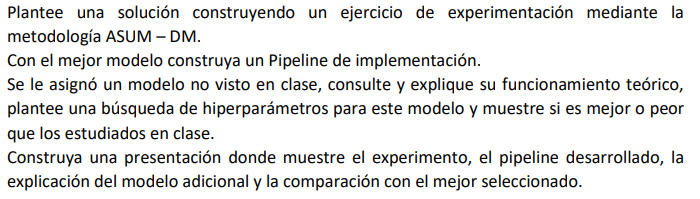



# **1. Entendimiento del Problema**

Como parte del **equipo de tarifación de una aseguradora**, se requiere construir un modelo predictivo que pueda pronosticar el valor de la prima de un asegurado con una precisión específica de MAPE menor o igual al
15%.


# **2. Enfoque Analítico**

Construir un modelo de regresion para predecir el valor de la prima de un asegurado con un MAPE menor al 15%. (Probabilidad superior al 85%) para la predicción del valor de las primas de seguros.

# **3. Requerimiento de Datos**

- Se requieren datos de los asegurados (Edad, genero, estado civil, hijos, tipo de trabajo, nivel educativo, ingresos anuales, tipo de residencia, valor de la prima)
- Datos historicos de primas pagadas por los asegurados

# **4. Recolección de Datos**
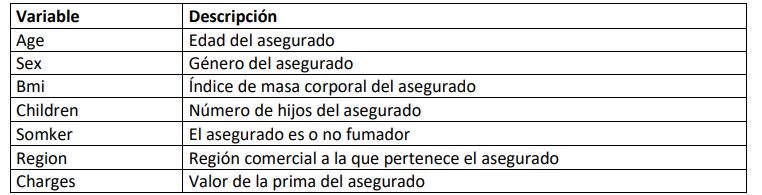

In [356]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
data1 = pd.read_csv('datos_caso_3.csv')
data=data1[data1['charges'] != 0]  #para quitar la variable y=0, creo que no existe 
data

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [357]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


# **5. Entendimiento de los Datos** 

- Conocer nuestra variable y (escencial ya que es lo que le va a decir al modelo los datos que quiero que se aprenda )
- identificar datos nulos
- analisis multivariado y univariado

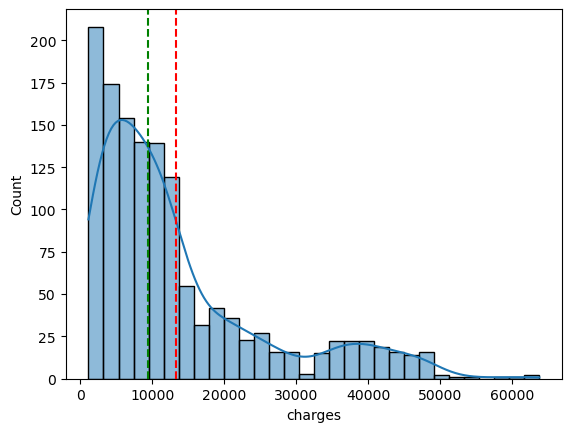

In [358]:
#la media y la mediana del conjunto con la variable x como changes y 
import matplotlib.pyplot as plt
import seaborn as sb

sb.histplot(data = data, x = 'charges', kde = True)
plt.axvline(x = data.charges.mean(), color = 'red', linestyle = 'dashed') 
plt.axvline(x = data.charges.median(), color = 'green', linestyle = 'dashed')
plt.show()
#áreas donla los charges son menores al 15 % y mayor al 15%
#La mediana y la media son cercanas, ahí hay una mayor frecuencia.
#No es normal, es muy dificil que siempre sea normal 


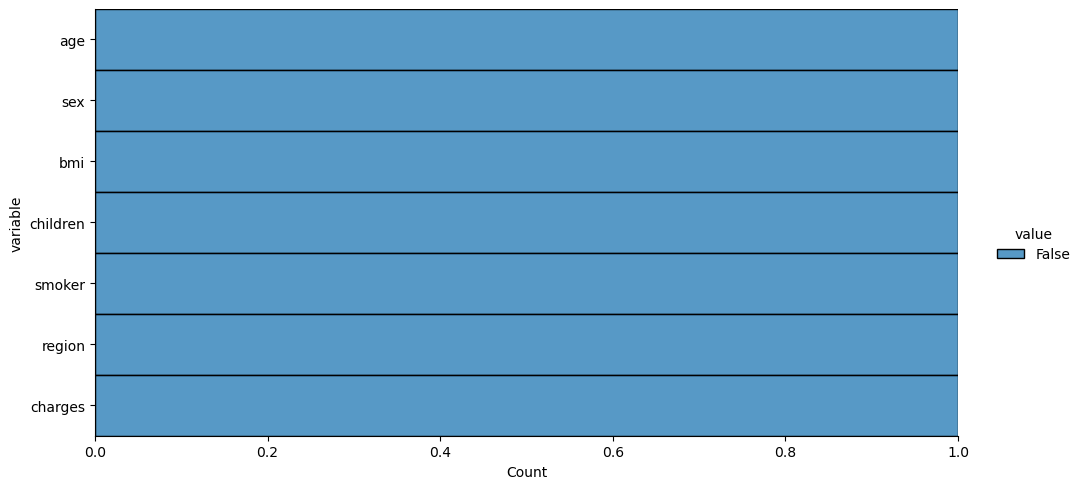

In [359]:
#no hay datos nulos 

data.isnull().melt().pipe(lambda df: sb.displot(data = df, y = 'variable', hue = 'value', multiple = 'fill', aspect=2))
plt.show()

## Exploración univariada de los datos 

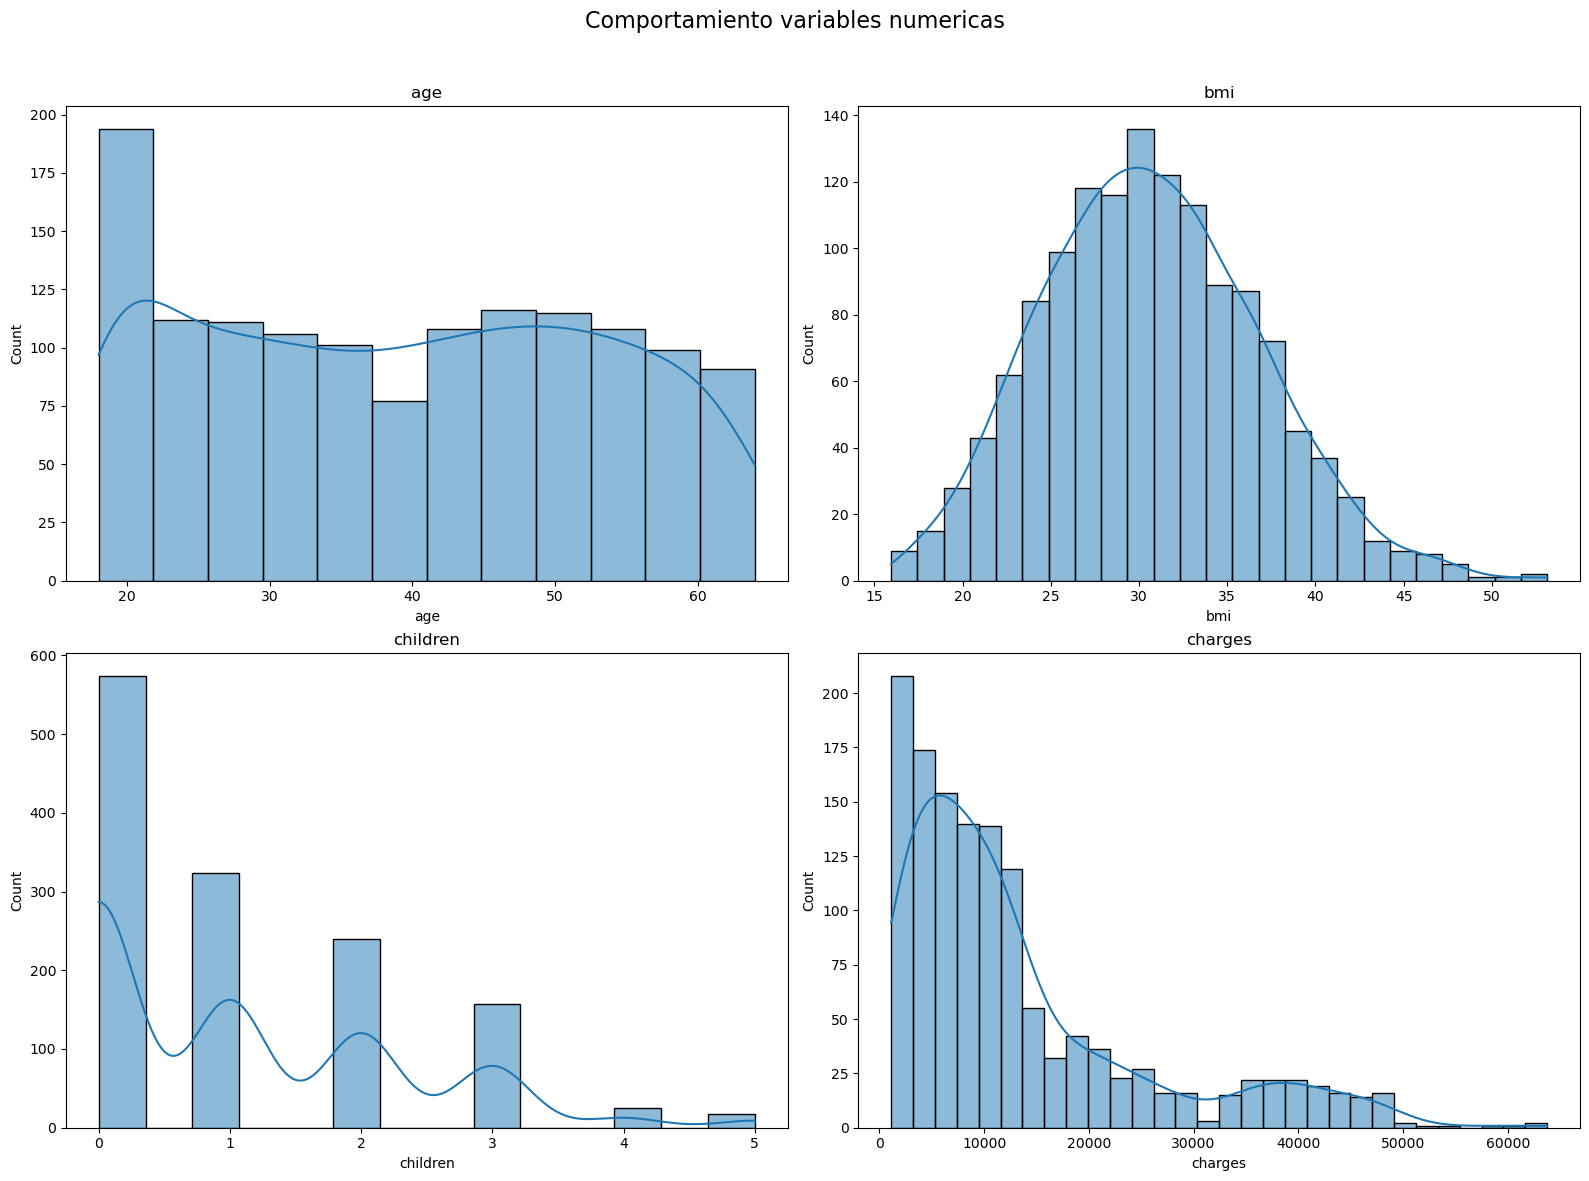

In [360]:
#Histograma de frecuencia para las variables numericas 
fig, ax = plt.subplots(2,2, figsize = (16,12))
ax = ax.flat 
num_cols = data.select_dtypes(include = ['int64', 'float64']).columns
for i, col in enumerate(num_cols):
    sb.histplot(data = data, 
                x = col, 
                kde = True, 
                ax = ax[i])
    ax[i].set_title(col)
fig.tight_layout()
fig.subplots_adjust(top=0.9)
fig.suptitle('Comportamiento variables numericas', fontsize = 16)
plt.show()


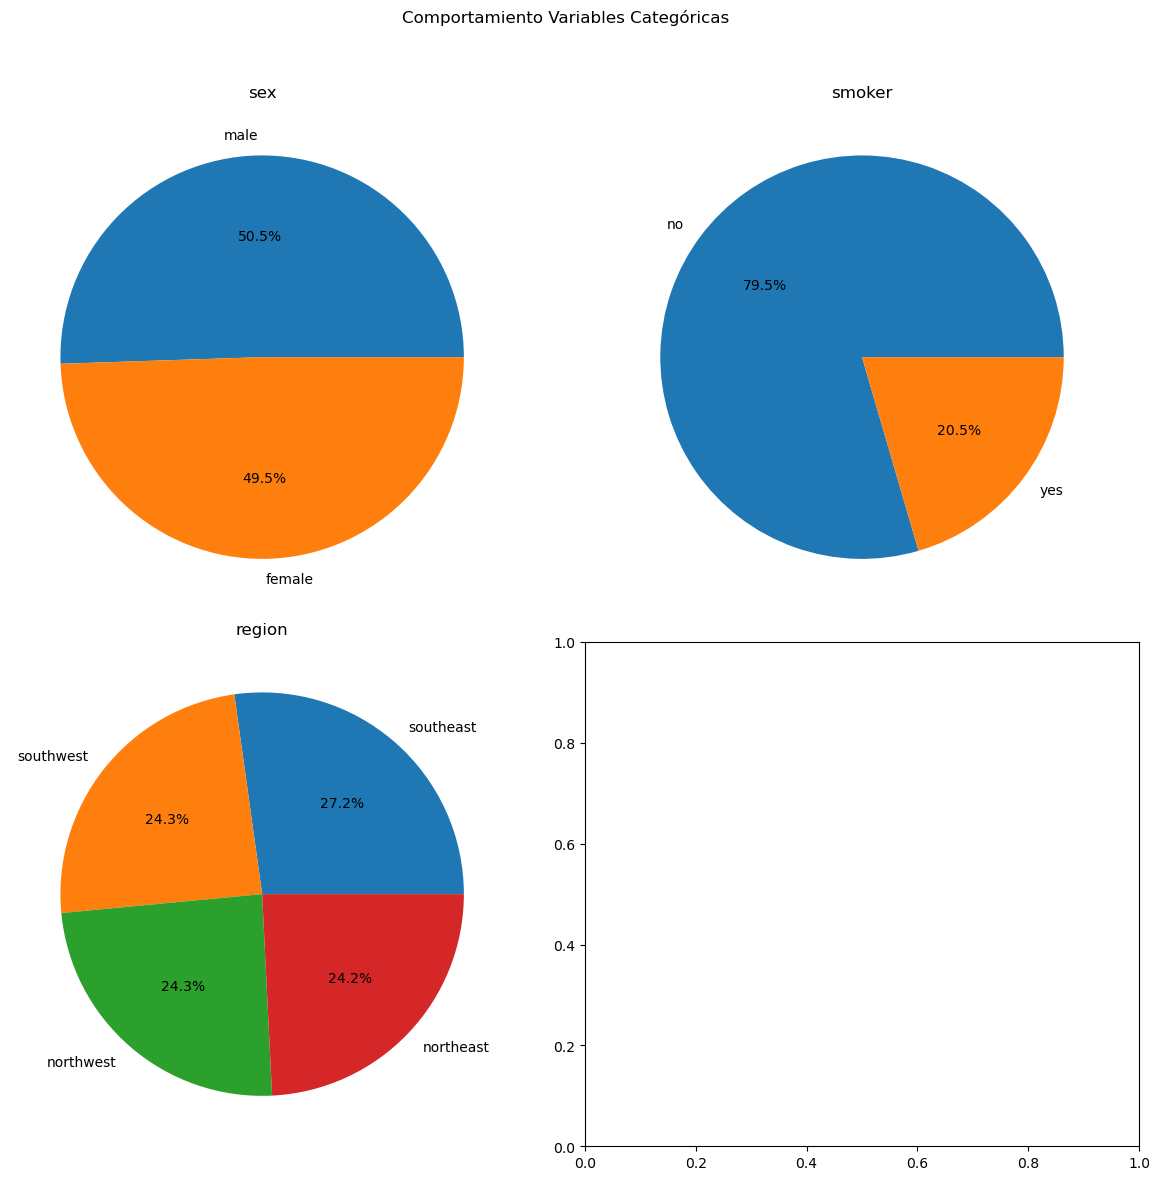

In [361]:
#graficos de torta para  las variables categoricas 
fig, ax = plt.subplots(2, 2, figsize = (12, 12))
ax = ax.flat
cat_col = data.select_dtypes(include = ['object']).columns
for i, col in enumerate(cat_col):
    ax[i].pie(x = data[col].value_counts(), labels = data[col].value_counts().index, autopct = '%0.1f%%')
    ax[i].set_title(col)
fig.tight_layout()
fig.subplots_adjust(top = 0.9)
fig.suptitle("Comportamiento Variables Categóricas")
plt.show()

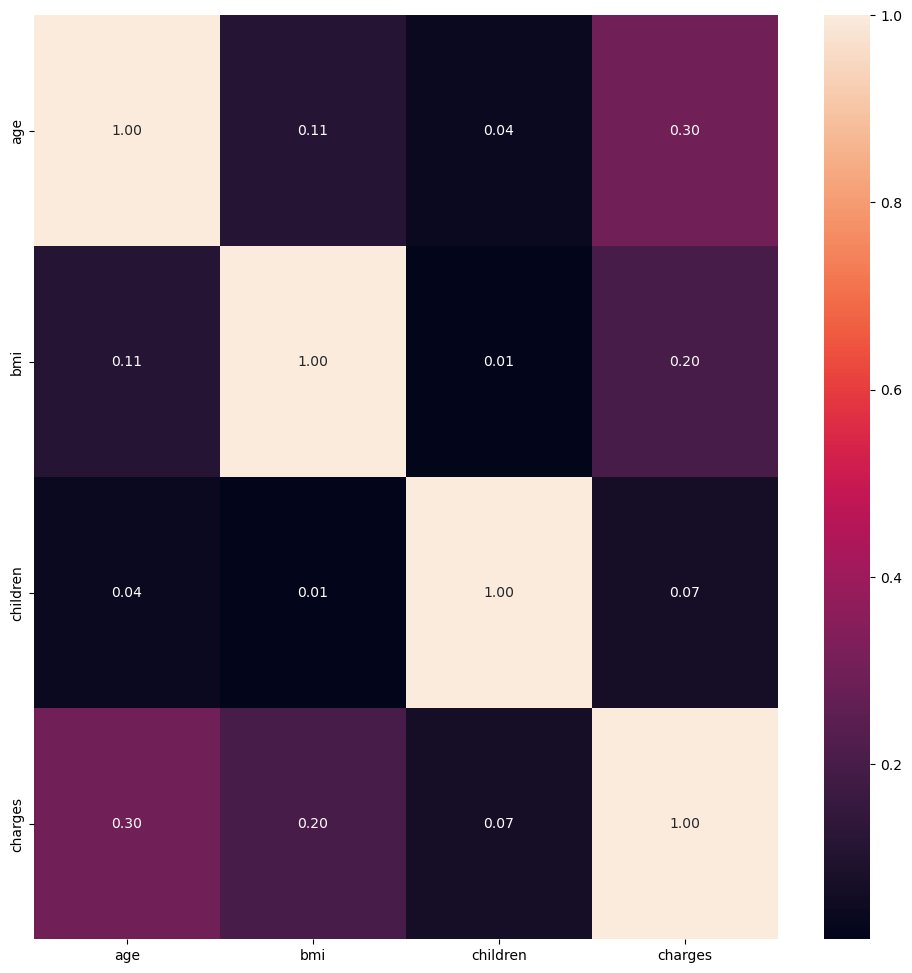

In [362]:
#correlacion
plt.figure(figsize = (12, 12))
sb.heatmap(data.corr(numeric_only=True), annot = True, fmt='.2f')
plt.show()

- Todos los datos del caso 3 están muy bien, no se encontró necesario hacer tratamiento de datos 

# **6. Preparación de los Datos**

- Eliminar variables que no son significativas
- Completar variables que cuentan con datos nulos
- Transformar los datos para que sean usables por el modelo


In [363]:

import sklearn
from sklearn.tree import DecisionTreeRegressor 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline



In [364]:
num_col = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_col = data.select_dtypes(include=['object']).columns.tolist()

num_transformer = Pipeline(steps = [('scaler', MinMaxScaler())])
cat_transformer = Pipeline(steps = [('encoder', OneHotEncoder())])

preprocessor = ColumnTransformer(
  transformers=[
    ('num', num_transformer, num_col),
    ('cat', cat_transformer, cat_col)
  ],
  remainder='passthrough'
)
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('scaler', MinMaxScaler())]),
                                 ['age', 'bmi', 'children', 'charges']),
                                ('cat',
                                 Pipeline(steps=[('encoder', OneHotEncoder())]),
                                 ['sex', 'smoker', 'region'])])

In [365]:
data_pre = preprocessor.fit_transform(data)

cod_cat = preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(cat_col)
labels = np.concatenate([num_col, cod_cat])

data_pro = pd.DataFrame(data_pre, columns=labels)
data_pro

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,0.021739,0.321227,0.0,0.251611,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.000000,0.479150,0.2,0.009636,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.217391,0.458434,0.6,0.053115,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.326087,0.181464,0.0,0.333010,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.304348,0.347592,0.0,0.043816,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1333,0.695652,0.403820,0.6,0.151299,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1334,0.000000,0.429379,0.0,0.017305,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1335,0.000000,0.562012,0.0,0.008108,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1336,0.065217,0.264730,0.0,0.014144,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


## Separación de la variable X y Y

In [366]:

X = data_pro.drop('charges', axis = 1)
y = data_pro[['charges']]

El tamaño del conjunto de entrenamiento es: (401, 11) (401, 1)
El tamaño del conjunto de prueba es: (937, 11) (937, 1)


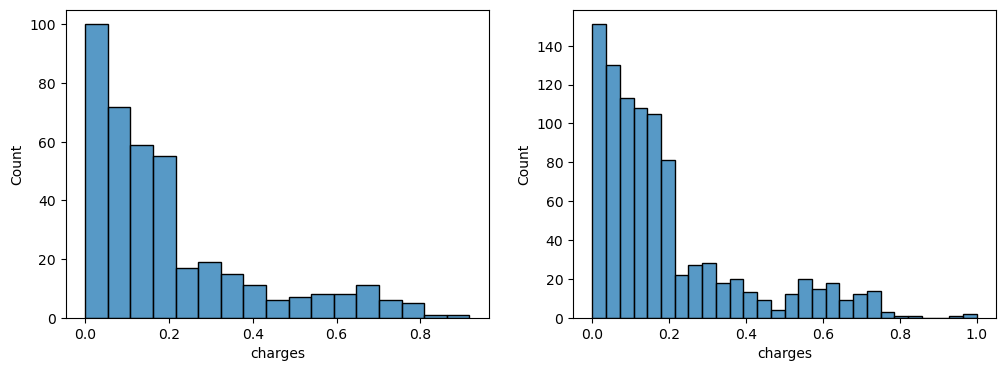

In [367]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=123)

print(f'El tamaño del conjunto de entrenamiento es: {X_train.shape} {y_train.shape}\nEl tamaño del conjunto de prueba es: {X_test.shape} {y_test.shape}')
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sb.histplot(data= y_train, x='charges', ax=ax[0])
sb.histplot(data= y_test, x='charges', ax=ax[1])
plt.show()

# **7. Modelado**

- Regresion Lineal
- K Vecinos Mas Cercanos
- Maquina de Soporte Vectorial
- Arboles de Decision
- Random Forest
- AdaBoost
- Gradient Boosting
- Perceptron Multicapa
- Hubber Regressor

# **8. Validación**
- Ajuste cuadratico
- Raiz del error cuadratico medio
- Error absoluto medio
- Porcentaje de error medio absoluto (MAPE)


In [368]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

## **Regresion Lineal**

In [369]:
modelo_1 = LinearRegression()
modelo_1.fit(X_train, y_train)

LinearRegression()

In [370]:
modelo_1.coef_
#Se pueden obtener coeficientes a traves de la linea recta, muchas veces la regresion linal asume comportamiento lineal cunso mucho de nuestros procesos no son lienales 
#se va a llegar hasta el despliegue en regresión 

array([[ 0.18152455,  0.24378779,  0.02183742,  0.00323495, -0.00323495,
        -0.18477517,  0.18477517,  0.00822192,  0.00804215, -0.01054098,
        -0.00572309]])

In [371]:
modelo_1.intercept_

array([0.11733013])

Las metricas de desempeño en entrenamiento para la regresion lineal son:
R2: 0.7425
RMSE: 0.1001
MAE: 0.0711
MAPE: 378147569471.1707


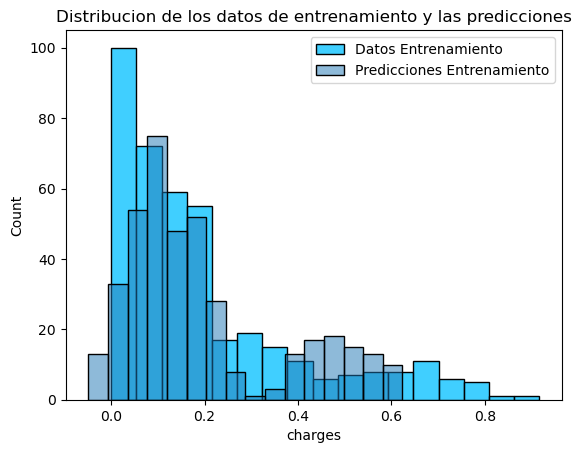

In [372]:
#Predicciones
pred_train_1 = modelo_1.predict(X_train)
pred_test_1 = modelo_1.predict(X_test)


#Desescalado de las predicciones y los valores reales
pred_train_des_1 = pred_train_1 * (np.max(y) - np.min(y)) + np.min(y)
pred_test_des_1 = pred_test_1 * (np.max(y) - np.min(y)) + np.min(y)

#Desescalado de los valores reales
y_train_des = y_train * (np.max(y) - np.min(y)) + np.min(y)
y_test_des = y_test * (np.max(y) - np.min(y)) + np.min(y)

#Validación del modelo
r2_train_1 = r2_score(y_train_des, pred_train_des_1)
rmse_train_1 = root_mean_squared_error(y_train_des, pred_train_des_1)
mae_train_1 = mean_absolute_error(y_train_des, pred_train_des_1)
mape_train_1 = mean_absolute_percentage_error(y_train_des, pred_train_des_1)
print(f'Las metricas de desempeño en entrenamiento para la regresion lineal son:\nR2: {r2_train_1:.4f}\nRMSE: {rmse_train_1:.4f}\nMAE: {mae_train_1:.4f}\nMAPE: {mape_train_1:.4f}')

#Visualizacion de las predicciones
sb.histplot(data = y_train_des, x ='charges' , color='deepskyblue',label = 'Datos Entrenamiento')
sb.histplot(pred_train_des_1, label = 'Predicciones Entrenamiento')
plt.legend()
plt.title('Distribucion de los datos de entrenamiento y las predicciones')
plt.show()

In [373]:
y_test_des 


,charges
650,0.138535
319,0.056597
314,0.538193
150,0.063902
336,0.175913
...,...
24,0.081120
29,0.600000
838,0.084286
199,0.219951


Las metricas de desempe;o en prueba para la regresion lineal son:
R2: 0.7511
RMSE: 0.0955
MAE: 0.0682
MAPE: 1.7777


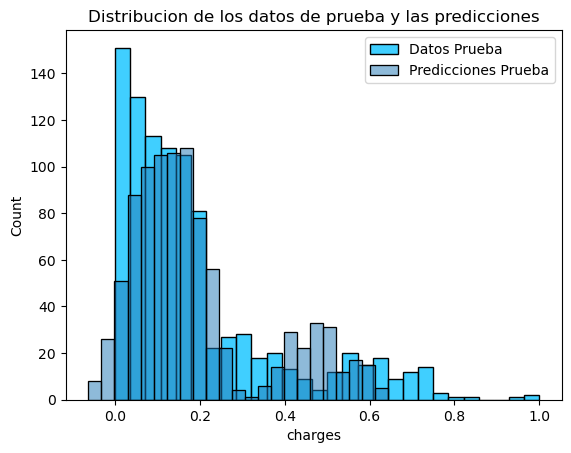

In [374]:
r2_test_1 = r2_score(y_test_des, pred_test_des_1)
rmse_test_1 = root_mean_squared_error(y_test_des, pred_test_des_1)
mae_test_1 = mean_absolute_error(y_test_des, pred_test_des_1)
mape_test_1 = mean_absolute_percentage_error(y_test_des, pred_test_des_1)
print(f'Las metricas de desempe;o en prueba para la regresion lineal son:\nR2: {r2_test_1:.4f}\nRMSE: {rmse_test_1:.4f}\nMAE: {mae_test_1:.4f}\nMAPE: {mape_test_1:.4f}')

#Visualizacion de las predicciones

sb.histplot(data = y_test_des, x ='charges' , color='deepskyblue',label = 'Datos Prueba')
sb.histplot(pred_test_des_1, label = 'Predicciones Prueba')
plt.legend()
plt.title('Distribucion de los datos de prueba y las predicciones')
plt.show()

## **K vecinos más cercanos**

In [375]:

modelo_2 = KNeighborsRegressor()
param_grid = {
    'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30, 100, 1000],
    'p': [1, 2],  # 1 para Manhattan, 2 para Euclidean
}

reg_2 = GridSearchCV(estimator=modelo_2,
                    param_grid=param_grid,
                    cv=3,
                    scoring='neg_mean_absolute_percentage_error',)
reg_2.fit(X_train, y_train)
validation = pd.concat([pd.DataFrame(reg_2.cv_results_['params']), 
                        pd.DataFrame(reg_2.cv_results_['mean_test_score'], columns=['MAPE'])], axis=1)
validation.sort_values(by='MAPE', ascending=False)
# Al usar MAPE, el mejor es el valor más cercano a 0, pero como sklearn usa el negativo, el mejor es el más cercano a 0 por la izquierda (el menos negativo)

,n_neighbors,p,MAPE
0,2,1,-2.272675e+09
1,2,2,-2.272675e+09
2,3,1,-5.346691e+10
6,5,1,-5.482447e+10
4,4,1,-6.729095e+10
8,6,1,-9.916768e+10
3,3,2,-1.084764e+11
5,4,2,-1.085480e+11
7,5,2,-1.180095e+11
10,7,1,-1.693669e+11


In [376]:
modelo_2_final = reg_2.best_estimator_
modelo_2_final
# Al usar MAPE, el mejor es el valor más cercano a 0, pero como sklearn usa el negativo, el mejor es el más cercano a 0 por la izquierda (el menos negativo)

KNeighborsRegressor(n_neighbors=2, p=1)

Las metricas de desempeño en entrenamiento para KNN son:
R2: 0.9128
RMSE: 0.0583
MAE: 0.0308
MAPE: 48682705701.8653


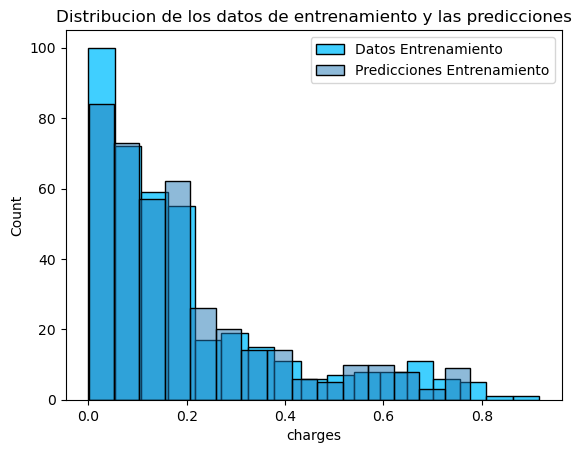

In [377]:
#Predicciones
pred_train_2 = modelo_2_final.predict(X_train)
pred_test_2 = modelo_2_final.predict(X_test)

pred_train_des_2 = pred_train_2 * (np.max(y) - np.min(y)) + np.min(y)
pred_test_des_2 = pred_test_2 * (np.max(y) - np.min(y)) + np.min(y) 

#Desescalado de los valores reales
y_train_des = y_train * (np.max(y) - np.min(y)) + np.min(y)
y_test_des = y_test * (np.max(y) - np.min(y)) + np.min(y)

#Validación del modelo
r2_train_2 = r2_score(y_train_des, pred_train_des_2)
rmse_train_2 = root_mean_squared_error(y_train_des, pred_train_des_2)
mae_train_2 = mean_absolute_error(y_train_des, pred_train_des_2)
mape_train_2 = mean_absolute_percentage_error(y_train_des, pred_train_des_2)
print(f'Las metricas de desempeño en entrenamiento para KNN son:\nR2: {r2_train_2:.4f}\nRMSE: {rmse_train_2:.4f}\nMAE: {mae_train_2:.4f}\nMAPE: {mape_train_2:.4f}')

#Visualizacion de las predicciones

sb.histplot(data = y_train_des, x ='charges' , color='deepskyblue',label = 'Datos Entrenamiento')
sb.histplot(pred_train_des_2, label = 'Predicciones Entrenamiento')
plt.legend()
plt.title('Distribucion de los datos de entrenamiento y las predicciones')
plt.show()


Las metricas de desempeño en prueba para KNN son:
R2: 0.6955
RMSE: 0.1056
MAE: 0.0615
MAPE: 0.4924


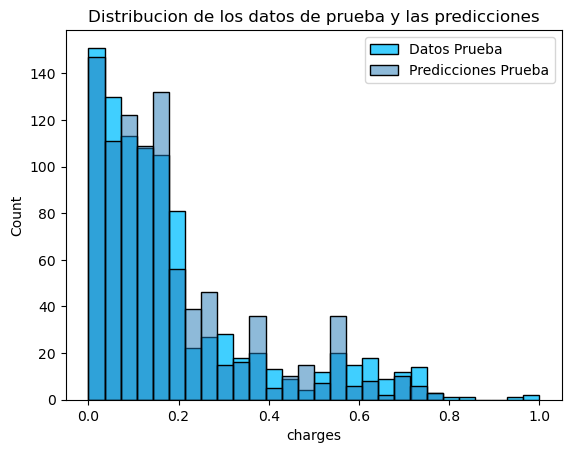

In [378]:
r2_test_2 = r2_score(y_test_des, pred_test_des_2)
rmse_test_2 = root_mean_squared_error(y_test_des, pred_test_des_2)
mae_test_2 = mean_absolute_error(y_test_des, pred_test_des_2)
mape_test_2 = mean_absolute_percentage_error(y_test_des, pred_test_des_2)

print(f'Las metricas de desempeño en prueba para KNN son:\nR2: {r2_test_2:.4f}\nRMSE: {rmse_test_2:.4f}\nMAE: {mae_test_2:.4f}\nMAPE: {mape_test_2:.4f}')
#Visualizacion de las predicciones
sb.histplot(data = y_test_des, x ='charges' , color='deepskyblue',label = 'Datos Prueba')
sb.histplot(pred_test_des_2, label = 'Predicciones Prueba')
plt.legend()
plt.title('Distribucion de los datos de prueba y las predicciones')
plt.show()

## **Maquina de soporte Vectorial**

In [379]:

modelo_3 = SVR()
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.001,0.01,0.1, 1, 10, 100, 1000], 
    'degree': [2,3,4,5]
}

reg_3 = GridSearchCV(estimator=modelo_3,
                    param_grid=param_grid,
                    cv=3,
                    scoring='neg_mean_absolute_percentage_error',)
reg_3.fit(X_train, y_train)
validation = pd.concat([pd.DataFrame(reg_3.cv_results_['params']), 
                        pd.DataFrame(reg_3.cv_results_['mean_test_score'], columns=['MAPE'])], axis=1)
validation.sort_values(by='MAPE', ascending=False)
# Al usar MAPE, el mejor es el valor más cercano a 0, pero como sklearn usa el negativo, el mejor es el más cercano a 0 por la izquierda (el menos negativo)

,C,degree,kernel,MAPE
32,0.1,2,linear,-5.731377e+09
36,0.1,3,linear,-5.731377e+09
44,0.1,5,linear,-5.731377e+09
40,0.1,4,linear,-5.731377e+09
77,10.0,5,poly,-2.621742e+10
...,...,...,...,...
87,100.0,3,sigmoid,-4.360355e+15
103,1000.0,3,sigmoid,-4.173758e+16
99,1000.0,2,sigmoid,-4.173758e+16
107,1000.0,4,sigmoid,-4.173758e+16


In [380]:
modelo_3_final = reg_3.best_estimator_
modelo_3_final

SVR(C=0.1, degree=2, kernel='linear')

Las metricas de desempeño en entrenamiento para SVM son:
R2: 0.7354
RMSE: 0.1015
MAE: 0.0764
MAPE: 253547964130.5365


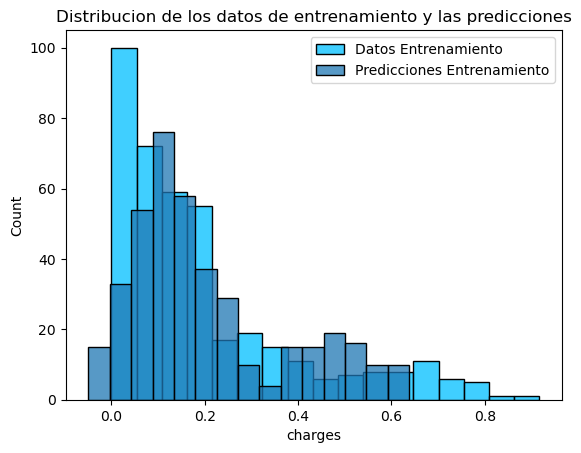

In [381]:
pred_train_3 = modelo_3_final.predict(X_train)
pred_test_3 = modelo_3_final.predict(X_test)

pred_train_des_3 = pred_train_3 * (np.max(y) - np.min(y)) + np.min(y)
pred_test_des_3 = pred_test_3 * (np.max(y) - np.min(y)) + np.min(y)

#Desescalado de los valores reales
y_train_des = y_train * (np.max(y) - np.min(y)) + np.min(y)
y_test_des = y_test * (np.max(y) - np.min(y)) + np.min(y)

#Validación del modelo
r2_train_3 = r2_score(y_train_des, pred_train_des_3)
rmse_train_3 = root_mean_squared_error(y_train_des, pred_train_des_3)
mae_train_3 = mean_absolute_error(y_train_des, pred_train_des_3)
mape_train_3 = mean_absolute_percentage_error(y_train_des, pred_train_des_3)

print(f'Las metricas de desempeño en entrenamiento para SVM son:\nR2: {r2_train_3:.4f}\nRMSE: {rmse_train_3:.4f}\nMAE: {mae_train_3:.4f}\nMAPE: {mape_train_3:.4f}')
#Visualizacion de las predicciones
sb.histplot(data = y_train_des, x ='charges' , color='deepskyblue',label = 'Datos Entrenamiento')
sb.histplot(pred_train_des_3, label = 'Predicciones Entrenamiento')
plt.legend()
plt.title('Distribucion de los datos de entrenamiento y las predicciones')
plt.show()

Las metricas de desempeño en prueba para SVM son:
R2: 0.7362
RMSE: 0.0983
MAE: 0.0751
MAPE: 2.6007


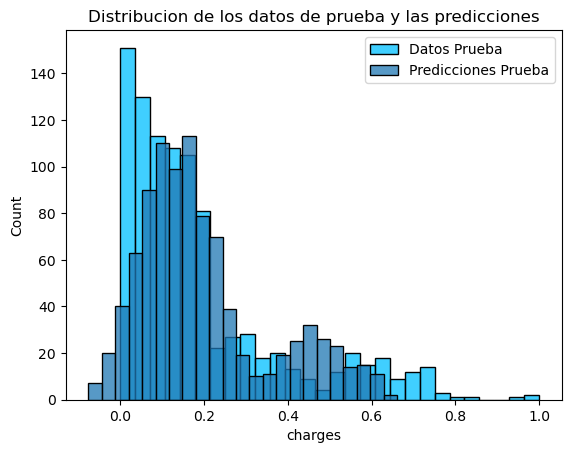

In [382]:
r2_test_3 = r2_score(y_test_des, pred_test_des_3)
rmse_test_3 = root_mean_squared_error(y_test_des, pred_test_des_3)
mae_test_3 = mean_absolute_error(y_test_des, pred_test_des_3)
mape_test_3 = mean_absolute_percentage_error(y_test_des, pred_test_des_3)
print(f'Las metricas de desempeño en prueba para SVM son:\nR2: {r2_test_3:.4f}\nRMSE: {rmse_test_3:.4f}\nMAE: {mae_test_3:.4f}\nMAPE: {mape_test_3:.4f}')
#Visualizacion de las predicciones
sb.histplot(data = y_test_des, x ='charges' , color='deepskyblue',label = 'Datos Prueba')
sb.histplot(pred_test_des_3, label = 'Predicciones Prueba')
plt.legend()
plt.title('Distribucion de los datos de prueba y las predicciones')
plt.show()

- tiene un ajuste de 73%.
- El mape no es buen indicador porque se tiene un cero en y da valores muy grandes.

## **Arbol de Regresión**

In [383]:

modelo_4 = DecisionTreeRegressor(random_state=123)
param_grid = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'max_depth': [None, 5, 7, 6, 3, 4, 10, 100, 1000, 20],
    'min_samples_split': [2,3,4],
    'max_leaf_nodes': [2,3,4, None]
}

reg_4 = GridSearchCV(estimator=modelo_4,
                    param_grid=param_grid,
                    cv=3,
                    scoring='neg_mean_absolute_percentage_error',)
reg_4.fit(X_train, y_train)
validation = pd.concat([pd.DataFrame(reg_4.cv_results_['params']), 
                        pd.DataFrame(reg_4.cv_results_['mean_test_score'], columns=['MAPE'])], axis=1)
validation.sort_values(by='MAPE', ascending=False)

# Al usar MAPE, el mejor es el valor más cercano a 0, pero como sklearn usa el negativo, el mejor es el más cercano a 0 por la izquierda (el menos negativo)

,criterion,max_depth,max_leaf_nodes,min_samples_split,MAPE
201,friedman_mse,10.0,NaN,2,-1.735497e+09
93,squared_error,100.0,NaN,2,-1.735497e+09
117,squared_error,20.0,NaN,2,-1.735497e+09
105,squared_error,1000.0,NaN,2,-1.735497e+09
9,squared_error,NaN,NaN,2,-1.735497e+09
...,...,...,...,...,...
433,poisson,10.0,2.0,3,-1.246471e+12
434,poisson,10.0,2.0,4,-1.246471e+12
444,poisson,100.0,2.0,2,-1.246471e+12
445,poisson,100.0,2.0,3,-1.246471e+12


In [384]:
modelo_4_final = reg_4.best_estimator_
modelo_4_final

DecisionTreeRegressor(criterion='friedman_mse', max_depth=10, random_state=123)

Las metricas de desempeño en entrenamiento para Arbol de Decision son:
R2: 0.9782
RMSE: 0.0291
MAE: 0.0082
MAPE: 0.1103


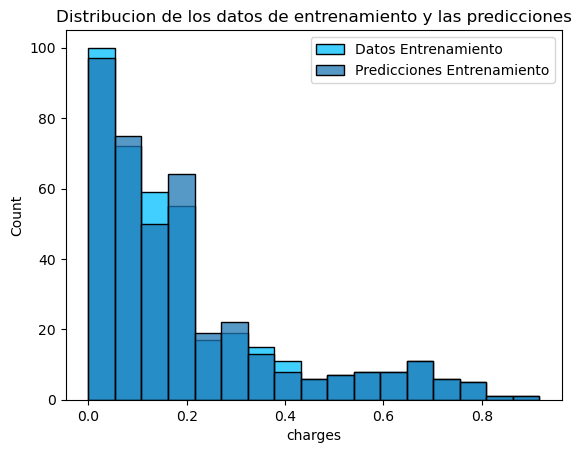

In [385]:
pred_train_4 = modelo_4_final.predict(X_train)
pred_test_4 = modelo_4_final.predict(X_test)

pred_train_des_4 = pred_train_4 * (np.max(y) - np.min(y)) + np.min(y)
pred_test_des_4 = pred_test_4 * (np.max(y) - np.min(y)) + np.min(y)

#Desescalado de los valores reales
y_train_des = y_train * (np.max(y) - np.min(y)) + np.min(y)
y_test_des = y_test * (np.max(y) - np.min(y)) + np.min(y)

#Validación del modelo
r2_train_4 = r2_score(y_train_des, pred_train_des_4)
rmse_train_4 = root_mean_squared_error(y_train_des, pred_train_des_4)
mae_train_4 = mean_absolute_error(y_train_des, pred_train_des_4)
mape_train_4 = mean_absolute_percentage_error(y_train_des, pred_train_des_4)

print(f'Las metricas de desempeño en entrenamiento para Arbol de Decision son:\nR2: {r2_train_4:.4f}\nRMSE: {rmse_train_4:.4f}\nMAE: {mae_train_4:.4f}\nMAPE: {mape_train_4:.4f}')
#Visualizacion de las predicciones
sb.histplot(data = y_train_des, x ='charges' , color='deepskyblue',label = 'Datos Entrenamiento')
sb.histplot(pred_train_des_4, label = 'Predicciones Entrenamiento')
plt.legend()
plt.title('Distribucion de los datos de entrenamiento y las predicciones')
plt.show()


Las metricas de desempeño en prueba para Arbol de Decision son:
R2: 0.7447
RMSE: 0.0967
MAE: 0.0488
MAPE: 0.5681


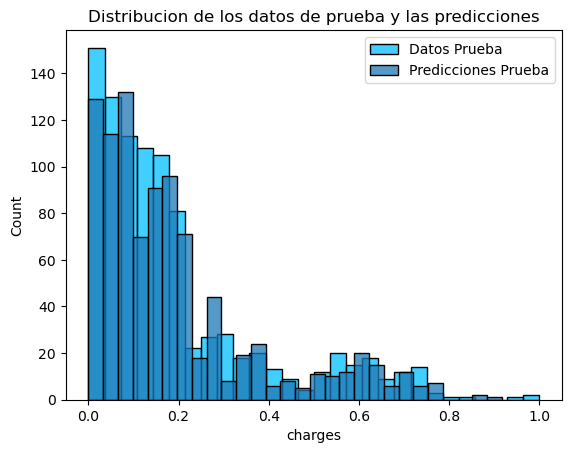

In [386]:
r2_test_4 = r2_score(y_test_des, pred_test_des_4)
rmse_test_4 = root_mean_squared_error(y_test_des, pred_test_des_4)
mae_test_4 = mean_absolute_error(y_test_des, pred_test_des_4)
mape_test_4 = mean_absolute_percentage_error(y_test_des, pred_test_des_4)
print(f'Las metricas de desempeño en prueba para Arbol de Decision son:\nR2: {r2_test_4:.4f}\nRMSE: {rmse_test_4:.4f}\nMAE: {mae_test_4:.4f}\nMAPE: {mape_test_4:.4f}')

#Visualizacion de las predicciones
sb.histplot(data = y_test_des, x ='charges' , color='deepskyblue',label = 'Datos Prueba')
sb.histplot(pred_test_des_4, label = 'Predicciones Prueba')
plt.legend()
plt.title('Distribucion de los datos de prueba y las predicciones')
plt.show()


## **Modelos de ensamblaje**

## **Bosque aleatorio**
Bosque aleatorio: Método de ensamblaje de tipo bagging (método de aprendizaje en parelelo tipo boostrap)
Toma el conjunto de datos y los divide en número n de datos. Construye un árbol de desición especiífico para cada uno de ellos, por eso es un bosque , ya que se toman varios árboles de desición, en clasificacion la votación se hacia por moda sino por media. 
    - Hiperparametros   : Casi siempre en 100 árboles se identífica un bosque, como está basado en árboles absorve los hiperparámetros del árbol como profundidad, criterio de pureza, cantidad de hojas.

In [387]:

modelo_5 = RandomForestRegressor(random_state=123)
param_grid = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'max_depth': [None, 5, 6, 3, 4, 10, 100],
    'max_leaf_nodes': [2,3,4, None],
    'n_estimators':[100,200,500]
    }


reg_5 = GridSearchCV(estimator=modelo_5,
                    param_grid=param_grid,
                    cv=3,
                    scoring='neg_mean_absolute_percentage_error',)
reg_5.fit(X_train, y_train)
validation = pd.concat([pd.DataFrame(reg_5.cv_results_['params']), 
                        pd.DataFrame(reg_5.cv_results_['mean_test_score'], columns=['MAPE'])], axis=1)
validation.sort_values(by='MAPE', ascending=False)


,criterion,max_depth,max_leaf_nodes,n_estimators,MAPE
333,poisson,100.0,NaN,100,-3.907394e+10
261,poisson,NaN,NaN,100,-3.907394e+10
321,poisson,10.0,NaN,100,-3.993508e+10
334,poisson,100.0,NaN,200,-4.135936e+10
262,poisson,NaN,NaN,200,-4.135936e+10
...,...,...,...,...,...
49,squared_error,4.0,2.0,200,-1.244059e+12
289,poisson,3.0,2.0,200,-1.244059e+12
277,poisson,6.0,2.0,200,-1.244059e+12
265,poisson,5.0,2.0,200,-1.244059e+12


In [388]:
modelo_5_final = reg_5.best_estimator_
modelo_5_final

RandomForestRegressor(criterion='poisson', random_state=123)

Las metricas de desempeño en entrenamiento para Bosque aleatorio son:
R2: 0.97661
RMSE: 0.03018
MAE: 0.01548
MAPE: 25048259888.66187


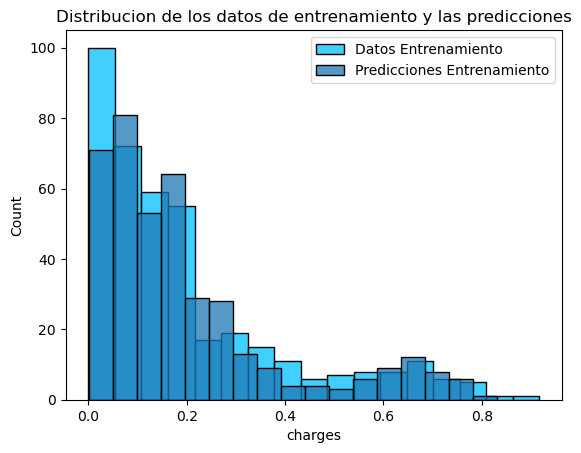

In [389]:
pred_train_5 = modelo_5_final.predict(X_train)
pred_test_5 = modelo_5_final.predict(X_test)

pred_train_des_5 = pred_train_5 * (np.max(y) - np.min(y)) + np.min(y)
pred_test_des_5 = pred_test_5 * (np.max(y) - np.min(y)) + np.min(y)

#Desescalado de los valores reales
y_train_des = y_train * (np.max(y) - np.min(y)) + np.min(y)
y_test_des = y_test * (np.max(y) - np.min(y)) + np.min(y)

#Validación del modelo
r2_train_5 = r2_score(y_train_des, pred_train_des_5)
rmse_train_5 = root_mean_squared_error(y_train_des, pred_train_des_5)
mae_train_5 = mean_absolute_error(y_train_des, pred_train_des_5)
mape_train_5 = mean_absolute_percentage_error(y_train_des, pred_train_des_5)

print(f'Las metricas de desempeño en entrenamiento para Bosque aleatorio son:\nR2: {r2_train_5:.5f}\nRMSE: {rmse_train_5:.5f}\nMAE: {mae_train_5:.5f}\nMAPE: {mape_train_5:.5f}')
#Visualizacion de las predicciones
sb.histplot(data = y_train_des, x ='charges' , color='deepskyblue',label = 'Datos Entrenamiento')
sb.histplot(pred_train_des_5, label = 'Predicciones Entrenamiento')
plt.legend()
plt.title('Distribucion de los datos de entrenamiento y las predicciones')
plt.show()


Las metricas de desepeños de prueba para bosque aleatorio son:
R2: 0.84377
RMSE: 0.07566
MAE: 0.04193
MAPE: 0.48157


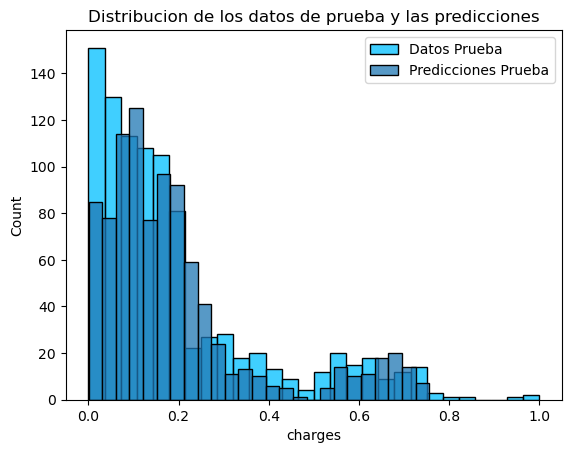

In [390]:
r2_test_5 = r2_score(y_test_des, pred_test_des_5)
rmse_test_5 = root_mean_squared_error(y_test_des, pred_test_des_5)
mae_test_5 = mean_absolute_error(y_test_des, pred_test_des_5)
mape_test_5 = mean_absolute_percentage_error(y_test_des, pred_test_des_5)
print(f'Las metricas de desepeños de prueba para bosque aleatorio son:\nR2: {r2_test_5:.5f}\nRMSE: {rmse_test_5:.5f}\nMAE: {mae_test_5:.5f}\nMAPE: {mape_test_5:.5f}')

#Visualizacion de las predicciones
sb.histplot(data = y_test_des, x ='charges' , color='deepskyblue',label = 'Datos Prueba')
sb.histplot(pred_test_des_5, label = 'Predicciones Prueba')
plt.legend()
plt.title('Distribucion de los datos de prueba y las predicciones')
plt.show()


## **Adaptative Boosting**
Se toman los datos, se esttima el primer modelo y toma una desición a partir del ensamblaje de ese primer modelo. 
Los coeficientes son el peso del modelo, la respuesta ensamblada el el coeficiento multiplicado por las predicciones del modelalo 1 más el modelo 2 por los coeficioentes del modelo 2 mas... Los coeficientes son lo que busca el modelo adaptativo, pues es lo que se va apredecir. Los alphas se encuentan con proceso de minimización, se puede juagar con los adaptadores base para encontrar mejor madelo, y ver como responde mejor 
    - Hiperparámetros: modelo base, cantidad de modelos base, tase de aprendizaje,  
En el adaptative tambien se implementan árboles ya que son los más fáciles para sobreajustar y de facil interpretacion.

In [391]:
modelo_6 = AdaBoostRegressor()

param_grid = {'n_estimators': [100,200,400,600], 'loss':['linear', 'square', 'exponential'],
              'learning_rate':[0.001, 0.01, 0.1,1,10]}

reg_6 = GridSearchCV(estimator=modelo_6, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_percentage_error')

reg_6.fit(X_train, y_train)

validation = pd.concat([pd.DataFrame(reg_6.cv_results_['params']), 
                        pd.DataFrame(reg_6.cv_results_['mean_test_score'], columns=['MAPE'])], axis=1)
validation.sort_values(by='MAPE', ascending=False)


,learning_rate,loss,n_estimators,MAPE
8,0.001,exponential,100,-4.091076e+11
1,0.001,linear,200,-4.248030e+11
9,0.001,exponential,200,-4.267437e+11
4,0.001,square,100,-4.276085e+11
5,0.001,square,200,-4.293884e+11
10,0.001,exponential,400,-4.328173e+11
6,0.001,square,400,-4.355002e+11
2,0.001,linear,400,-4.358367e+11
11,0.001,exponential,600,-4.366462e+11
20,0.010,exponential,100,-4.402087e+11


In [392]:
modelo_6_final = reg_6.best_estimator_
modelo_6_final

AdaBoostRegressor(learning_rate=0.001, loss='exponential', n_estimators=100)

Las metricas de desempeño en entrenamiento para AdaBoost son:
R2: 0.8689
RMSE: 0.0715
MAE: 0.0413
MAPE: 397094488813.6480


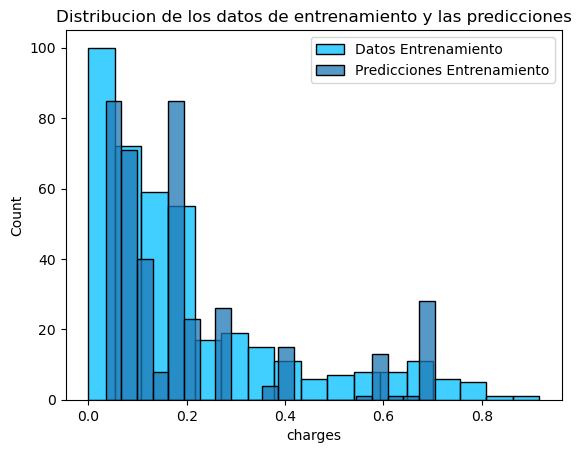

In [393]:
pred_train_6 = modelo_6_final.predict(X_train)
pred_test_6 = modelo_6_final.predict(X_test)

pred_train_des_6 = pred_train_6 * (np.max(y) - np.min(y)) + np.min(y)
pred_test_des_6 = pred_test_6 * (np.max(y) - np.min(y)) + np.min(y)

#Desescalado de los valores reales
y_train_des = y_train * (np.max(y) - np.min(y)) + np.min(y)
y_test_des = y_test * (np.max(y) - np.min(y)) + np.min(y)

#Validación del modelo
r2_train_6 = r2_score(y_train_des, pred_train_des_6)
rmse_train_6 = root_mean_squared_error(y_train_des, pred_train_des_6)
mae_train_6 = mean_absolute_error(y_train_des, pred_train_des_6)
mape_train_6 = mean_absolute_percentage_error(y_train_des, pred_train_des_6)

print(f'Las metricas de desempeño en entrenamiento para AdaBoost son:\nR2: {r2_train_6:.4f}\nRMSE: {rmse_train_6:.4f}\nMAE: {mae_train_6:.4f}\nMAPE: {mape_train_6:.4f}')
#Visualizacion de las predicciones
sb.histplot(data = y_train_des, x ='charges' , color='deepskyblue',label = 'Datos Entrenamiento')
sb.histplot(pred_train_des_6, label = 'Predicciones Entrenamiento')
plt.legend()
plt.title('Distribucion de los datos de entrenamiento y las predicciones')
plt.show()


Las metricas de desempeño en prueba para AdaBoost son:
R2: 0.8535
RMSE: 0.0733
MAE: 0.0430
MAPE: 1.2894


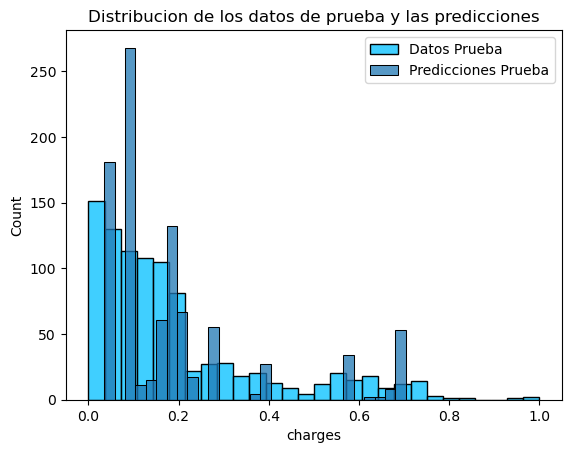

In [394]:
r2_test_6 = r2_score(y_test_des, pred_test_des_6)
rmse_test_6 = root_mean_squared_error(y_test_des, pred_test_des_6)
mae_test_6 = mean_absolute_error(y_test_des, pred_test_des_6)
mape_test_6 = mean_absolute_percentage_error(y_test_des, pred_test_des_6)
print(f'Las metricas de desempeño en prueba para AdaBoost son:\nR2: {r2_test_6:.4f}\nRMSE: {rmse_test_6:.4f}\nMAE: {mae_test_6:.4f}\nMAPE: {mape_test_6:.4f}')
#Visualizacion de las predicciones
sb.histplot(data = y_test_des, x ='charges' , color='deepskyblue',label = 'Datos Prueba')
sb.histplot(pred_test_des_6, label = 'Predicciones Prueba')
plt.legend()
plt.title('Distribucion de los datos de prueba y las predicciones')
plt.show()


## **Gradient Boosting**
- Si o si utiliza árboles de desición. Parte de los hiperparametros son los mismos del árboles de desición. 
- Utiliza el error para predecir el siguiente modelo, ahí crea el gradiente 
- Osea que toma un modelo y a traves de este trata de predecir a las y, con eso cálcula los residuos, esos elementos los usa para ajustar el sigiente modelo, las respuestas para comparar no son la y resal sino las presicciones. Se empieza a crear una ecuación de gradiente, que es el valor que se le aportará a cada modificacion .
- La diferencia con la del gradiente es qie existe un unico parametro que define la cantidad de info que se la va a dar a los modelos pequeños. 
- Gamma es el valor generalizado del modelo, hay que encontrarlo. Si me equivoco mucho en el primero el residual va a ser muy grande 
- vamos a tener la forma d ela resta y de la pérdida como hiperparametros 

In [395]:
modelo_7 = GradientBoostingRegressor()

param_grid = {
  'n_estimators': [500, 600, 700, 800, 900, 1000],
  'loss': ['squared_error', 'absolute_error'],
  'criterion': ['friedman_mse', 'squared_error'],
}

modelo_7_final = None
mape_test_7 = 1
intento = 1

print("nos tocó buscarlo así")
print("=" * 60)
print("Objetivo: Lograr MAPE ≤ 15% en conjunto de test")
print("=" * 60)

while True:
  print(f"\n INTENTO {intento}")
  print("-" * 40)

  X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.7)


  reg_7 = GridSearchCV(estimator=modelo_7, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_percentage_error')
  reg_7.fit(X_train_2, y_train_2)

  validation = pd.concat([pd.DataFrame(reg_7.cv_results_['params']), 
                        pd.DataFrame(reg_7.cv_results_['mean_test_score'], columns=['MAPE'])], axis=1)
  validation.sort_values(by='MAPE', ascending=False)

  modelo_7_final = reg_7.best_estimator_
  
  print(f" Mejores parámetros: {reg_7.best_params_}")
  
  pred_train_7 = modelo_7_final.predict(X_train)
  pred_test_7 = modelo_7_final.predict(X_test)
  pred_train_des_7 = pred_train_7 * (np.max(y) - np.min(y)) + np.min(y)
  pred_test_des_7 = pred_test_7 * (np.max(y) - np.min(y)) + np.min(y)
  y_train_des = y_train * (np.max(y) - np.min(y)) + np.min(y)
  y_test_des = y_test * (np.max(y) - np.min(y)) + np.min(y)
  r2_train_7 = r2_score(y_train_des, pred_train_des_7)
  rmse_train_7 = root_mean_squared_error(y_train_des, pred_train_des_7)
  mae_train_7 = mean_absolute_error(y_train_des, pred_train_des_7)
  mape_train_7 = mean_absolute_percentage_error(y_train_des, pred_train_des_7)
  

##
  r2_test_7 = r2_score(y_test_des, pred_test_des_7)
  rmse_test_7 = root_mean_squared_error(y_test_des, pred_test_des_7)
  mae_test_7 = mean_absolute_error(y_test_des, pred_test_des_7)
  mape_test_7 = mean_absolute_percentage_error(y_test_des, pred_test_des_7)

  print(f" RESULTADOS:")
  print(f"   MAPE Train: {mape_train_7:.4f} ({mape_train_7*100:.2f}%)")
  print(f"   MAPE Test:  {mape_test_7:.4f} ({mape_test_7*100:.2f}%)")


  if mape_test_7 >= 0.15:
    print(f"    MAPE Test > 15% - Continuando búsqueda...")
  else:
    print(f"   ¡Por fin! MAPE Test ≤ 15%")
    print(f"   Modelo final encontrado en intento {intento}")
    break 

  intento += 1
  
  # Agregar límite de seguridad para evitar bucle infinito

  if intento > 30:
    print(f"\n  Se alcanzó el límite de 30 intentos. Deteniendo búsqueda.")
    print(f"   Mejor resultado obtenido: MAPE Test = {mape_test_7*100:.2f}%")
    break

print("\n" + "=" * 60)
print(" BÚSQUEDA COMPLETADA")
print("=" * 60)

modelo_7_final



nos tocó buscarlo así
Objetivo: Lograr MAPE ≤ 15% en conjunto de test

 INTENTO 1
----------------------------------------
 Mejores parámetros: {'criterion': 'friedman_mse', 'loss': 'absolute_error', 'n_estimators': 500}
 RESULTADOS:
   MAPE Train: 4006114375.6255 (400611437562.55%)
   MAPE Test:  0.1606 (16.06%)
    MAPE Test > 15% - Continuando búsqueda...

 INTENTO 2
----------------------------------------
 Mejores parámetros: {'criterion': 'squared_error', 'loss': 'absolute_error', 'n_estimators': 900}
 RESULTADOS:
   MAPE Train: 29327762800.2166 (2932776280021.66%)
   MAPE Test:  0.2044 (20.44%)
    MAPE Test > 15% - Continuando búsqueda...

 INTENTO 3
----------------------------------------
 Mejores parámetros: {'criterion': 'squared_error', 'loss': 'absolute_error', 'n_estimators': 700}
 RESULTADOS:
   MAPE Train: 115638210082.7202 (11563821008272.02%)
   MAPE Test:  0.1387 (13.87%)
   ¡Por fin! MAPE Test ≤ 15%
   Modelo final encontrado en intento 3

 BÚSQUEDA COMPLETADA


GradientBoostingRegressor(criterion='squared_error', loss='absolute_error',
                          n_estimators=700)

In [396]:
modelo_7_final

GradientBoostingRegressor(criterion='squared_error', loss='absolute_error',
                          n_estimators=700)

Las metricas de desempeño en entrenamiento para Gradient Boosting son:
R2: 0.8165
RMSE: 0.0845
MAE: 0.0337
MAPE: 115638210082.7202


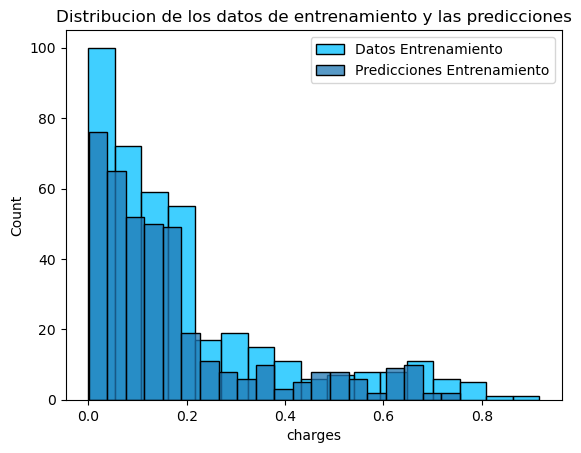

Las metricas de desempeño en prueba para Gradient Boosting son:
R2: 0.7975
RMSE: 0.0861
MAE: 0.0353
MAPE: 0.1387


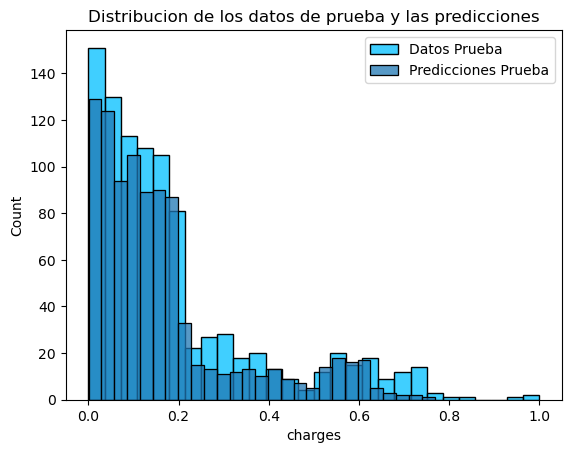

In [397]:

print(f'Las metricas de desempeño en entrenamiento para Gradient Boosting son:\nR2: {r2_train_7:.4f}\nRMSE: {rmse_train_7:.4f}\nMAE: {mae_train_7:.4f}\nMAPE: {mape_train_7:.4f}')
#Visualizacion de las predicciones
sb.histplot(data = y_train_des, x ='charges' , color='deepskyblue',label = 'Datos Entrenamiento')
sb.histplot(pred_train_des_7, label = 'Predicciones Entrenamiento')
plt.legend()
plt.title('Distribucion de los datos de entrenamiento y las predicciones')
plt.show()

print(f'Las metricas de desempeño en prueba para Gradient Boosting son:\nR2: {r2_test_7:.4f}\nRMSE: {rmse_test_7:.4f}\nMAE: {mae_test_7:.4f}\nMAPE: {mape_test_7:.4f}')
#Visualizacion de las predicciones
sb.histplot(data = y_test_des, x ='charges' , color='deepskyblue',label = 'Datos Prueba')
sb.histplot(pred_test_des_7, label = 'Predicciones Prueba')
plt.legend()
plt.title('Distribucion de los datos de prueba y las predicciones')
plt.show()


## **Perceptron Multicapa**
- La mas sencilla es la multicapa (grafo dirigido )
- Estas redes se mapean a traves de nodos como si se tratara de un grafo (dentro de cada nodo hay un nucleo interno para porder procesar de forma conciente todos los elementos que ingresen), tipos:
    - nodos de entrada : funcion de activavcion en la cuncion identidad( lo que entra sale de manera igual, no modifican la información)
    - de salida : 
    - de capa oculta
    (cada neurona por dentro tiene una funcion de activación)

In [398]:

modelo_8 = MLPRegressor(random_state=123)

param_grid = {
    'hidden_layer_sizes': [
        (32,),        # pequeña
        (64,),        # moderada
        (100,),      
        (64, 32),     # 2 capas peque
        (100, 50),    # 2 capas con capa más grande primero
        (128, 64, 32) # 3 capas 
    ],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd', 'lbfgs'],
    'learning_rate_init': [0.0001, 0.001, 0.01, 0.1,1,10],
    'max_iter': [200, 300, 500]
}


reg_8 =GridSearchCV(estimator=modelo_8,
                          param_grid=param_grid,   
                            cv=3,
                            scoring='neg_mean_absolute_percentage_error',
                            n_jobs=-1)
reg_8.fit(X_train, y_train)

validation = pd.concat([pd.DataFrame(reg_8.cv_results_['params']), 
                        pd.DataFrame(reg_8.cv_results_['mean_test_score'], columns=['MAPE'])], axis=1)
validation.sort_values(by='MAPE', ascending=False)

,activation,hidden_layer_sizes,learning_rate_init,max_iter,solver,MAPE
44,relu,"(32,)",1.0000,500,lbfgs,-2.486698e+09
35,relu,"(32,)",0.1000,500,lbfgs,-2.486698e+09
53,relu,"(32,)",10.0000,500,lbfgs,-2.486698e+09
26,relu,"(32,)",0.0100,500,lbfgs,-2.486698e+09
8,relu,"(32,)",0.0001,500,lbfgs,-2.486698e+09
...,...,...,...,...,...,...
310,relu,"(128, 64, 32)",1.0000,300,sgd,NaN
313,relu,"(128, 64, 32)",1.0000,500,sgd,NaN
316,relu,"(128, 64, 32)",10.0000,200,sgd,NaN
319,relu,"(128, 64, 32)",10.0000,300,sgd,NaN


In [399]:
modelo_8_final = reg_8.best_estimator_
modelo_8_final

MLPRegressor(hidden_layer_sizes=(32,), learning_rate_init=0.0001, max_iter=500,
             random_state=123, solver='lbfgs')

Las metricas de desempeño en entrenamiento para Perceptron Multicapa son:
R2: 0.9151
RMSE: 0.0575
MAE: 0.0379
MAPE: 299948879023.3304


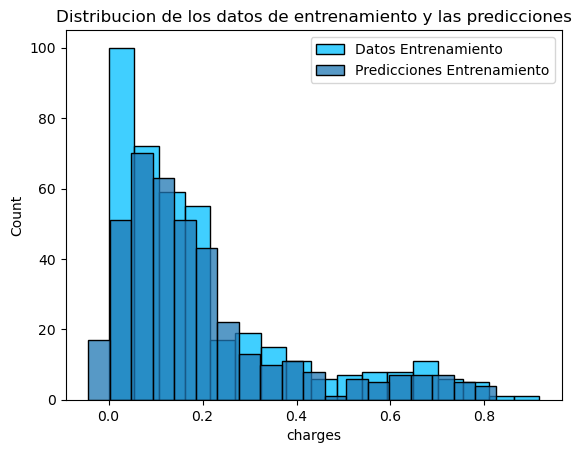

In [400]:
pred_train_8 = modelo_8_final.predict(X_train)
pred_test_8 = modelo_8_final.predict(X_test)

pred_train_des_8 = pred_train_8 * (np.max(y) - np.min(y)) + np.min(y)
pred_test_des_8 = pred_test_8 * (np.max(y) - np.min(y)) + np.min(y)

#Desescalado de los valores reales
y_train_des = y_train * (np.max(y) - np.min(y)) + np.min(y)
y_test_des = y_test * (np.max(y) - np.min(y)) + np.min(y)

#Validación del modelo
r2_train_8 = r2_score(y_train_des, pred_train_des_8)
rmse_train_8 = root_mean_squared_error(y_train_des, pred_train_des_8)
mae_train_8 = mean_absolute_error(y_train_des, pred_train_des_8)
mape_train_8 = mean_absolute_percentage_error(y_train_des, pred_train_des_8)

print(f'Las metricas de desempeño en entrenamiento para Perceptron Multicapa son:\nR2: {r2_train_8:.4f}\nRMSE: {rmse_train_8:.4f}\nMAE: {mae_train_8:.4f}\nMAPE: {mape_train_8:.4f}')
#Visualizacion de las predicciones

sb.histplot(data = y_train_des, x ='charges' , color='deepskyblue',label = 'Datos Entrenamiento')
sb.histplot(pred_train_des_8, label = 'Predicciones Entrenamiento')
plt.legend()
plt.title('Distribucion de los datos de entrenamiento y las predicciones')
plt.show()


Las metricas de desempeño en prueba para Perceptron Multicapa son:
R2: 0.7086
RMSE: 0.1033
MAE: 0.0666
MAPE: 0.8880


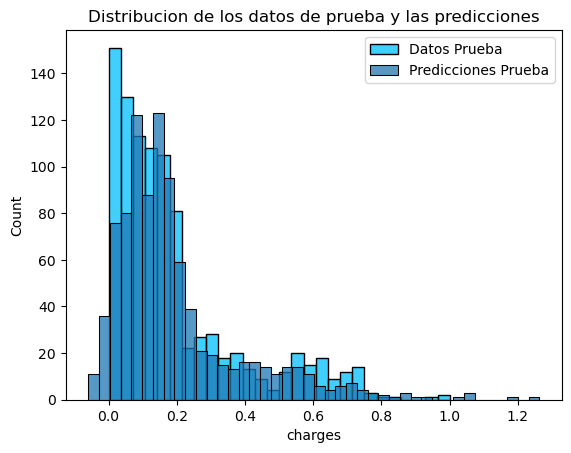

In [401]:
r2_test_8 = r2_score(y_test_des, pred_test_des_8)
rmse_test_8 = root_mean_squared_error(y_test_des, pred_test_des_8)
mae_test_8 = mean_absolute_error(y_test_des, pred_test_des_8)
mape_test_8 = mean_absolute_percentage_error(y_test_des, pred_test_des_8)

print(f'Las metricas de desempeño en prueba para Perceptron Multicapa son:\nR2: {r2_test_8:.4f}\nRMSE: {rmse_test_8:.4f}\nMAE: {mae_test_8:.4f}\nMAPE: {mape_test_8:.4f}')
sb.histplot(data = y_test_des, x ='charges' , color='deepskyblue',label = 'Datos Prueba')
sb.histplot(pred_test_des_8, label = 'Predicciones Prueba')
plt.legend()
plt.title('Distribucion de los datos de prueba y las predicciones')
plt.show()


## **Huber Regressor**

El Huber Regressor es un modelo de regresión robusto frente a valores atípicos (outliers).  
Su funcionamiento se basa en la **función de pérdida de Huber**, que combina lo mejor de la regresión lineal clásica y la regresión robusta:

- Para errores pequeños (residuales cercanos a 0) utiliza el **error cuadrático** (como la regresión lineal).  
- Para errores grandes (posibles outliers) utiliza el **error absoluto**, reduciendo el impacto de estos en el modelo.

La transición entre ambas zonas está controlada por el hiperparámetro `epsilon (ε)`:
- Valores pequeños → modelo más sensible a outliers.  
- Valores grandes → modelo se comporta más como una regresión lineal clásica.  

Otros hiperparámetros importantes:
- `alpha`: controla la regularización L2.  
- `epsilon`: umbral de corte entre error cuadrático y absoluto.  
- `max_iter`: número máximo de iteraciones.  


In [402]:
from sklearn.linear_model import HuberRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import GridSearchCV




In [403]:

modelo_9 = HuberRegressor()
param_grid_9 = {
    "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10 , 100, 1000], 
    "epsilon": [1.1, 1.35, 1.5, 1.75, 2.0], # umbral hubber 
    "fit_intercept":[True],
    "max_iter": [100, 250, 500, 750, 1000], #número máximo de iteraciones del algoritmo de optimización
    "tol":[0.00001, 0.0001, 0.001],
    "warm_start":[False],
}


reg_9 = GridSearchCV(
    estimator=modelo_9,
    param_grid=param_grid_9,
    scoring="neg_mean_absolute_percentage_error",  # maximize neg MAPE -> minimize MAPE
    cv=3,
    n_jobs=-1,
    verbose=1
)

reg_9.fit(X_train, y_train)
validation = pd.concat([pd.DataFrame(reg_9.cv_results_['params']), 
                        pd.DataFrame(reg_6.cv_results_['mean_test_score'], columns=['MAPE'])], axis=1)
validation.sort_values(by='MAPE', ascending=False)

Fitting 3 folds for each of 600 candidates, totalling 1800 fits


,alpha,epsilon,fit_intercept,max_iter,tol,warm_start,MAPE
8,0.0001,1.1,True,500,0.00100,False,-4.091076e+11
1,0.0001,1.1,True,100,0.00010,False,-4.248030e+11
9,0.0001,1.1,True,750,0.00001,False,-4.267437e+11
4,0.0001,1.1,True,250,0.00010,False,-4.276085e+11
5,0.0001,1.1,True,250,0.00100,False,-4.293884e+11
...,...,...,...,...,...,...,...
595,1000.0000,2.0,True,750,0.00010,False,NaN
596,1000.0000,2.0,True,750,0.00100,False,NaN
597,1000.0000,2.0,True,1000,0.00001,False,NaN
598,1000.0000,2.0,True,1000,0.00010,False,NaN


In [404]:
modelo_9_final = reg_9.best_estimator_
modelo_9_final

HuberRegressor(alpha=100, epsilon=1.75)

Las metricas de desempeño en entrenamiento para Perceptron Multicapa son:
R2: 0.6564
RMSE: 0.1157
MAE: 0.0621
MAPE: 35652068577.9803


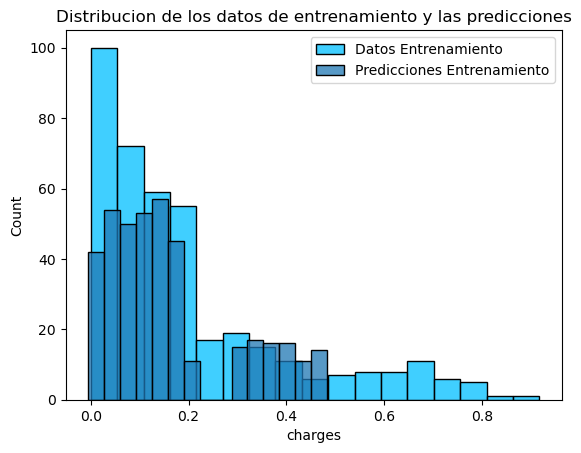

In [405]:
pred_train_9 = modelo_9_final.predict(X_train)
pred_test_9 = modelo_9_final.predict(X_test)

pred_train_des_9 = pred_train_9 * (np.max(y) - np.min(y)) + np.min(y)
pred_test_des_9 = pred_test_9 * (np.max(y) - np.min(y)) + np.min(y)

#Desescalado de los valores reales
y_train_des = y_train * (np.max(y) - np.min(y)) + np.min(y)
y_test_des = y_test * (np.max(y) - np.min(y)) + np.min(y)

#Validación del modelo
r2_train_9 = r2_score(y_train_des, pred_train_des_9)
rmse_train_9 = root_mean_squared_error(y_train_des, pred_train_des_9)
mae_train_9 = mean_absolute_error(y_train_des, pred_train_des_9)
mape_train_9 = mean_absolute_percentage_error(y_train_des, pred_train_des_9)

print(f'Las metricas de desempeño en entrenamiento para Perceptron Multicapa son:\nR2: {r2_train_9:.4f}\nRMSE: {rmse_train_9:.4f}\nMAE: {mae_train_9:.4f}\nMAPE: {mape_train_9:.4f}')
#Visualizacion de las predicciones

sb.histplot(data = y_train_des, x ='charges' , color='deepskyblue',label = 'Datos Entrenamiento')
sb.histplot(pred_train_des_9, label = 'Predicciones Entrenamiento')
plt.legend()
plt.title('Distribucion de los datos de entrenamiento y las predicciones')
plt.show()

Las metricas de desempeño en prueba para Perceptron Multicapa son:
R2: 0.6674
RMSE: 0.1104
MAE: 0.0601
MAPE: 0.7483


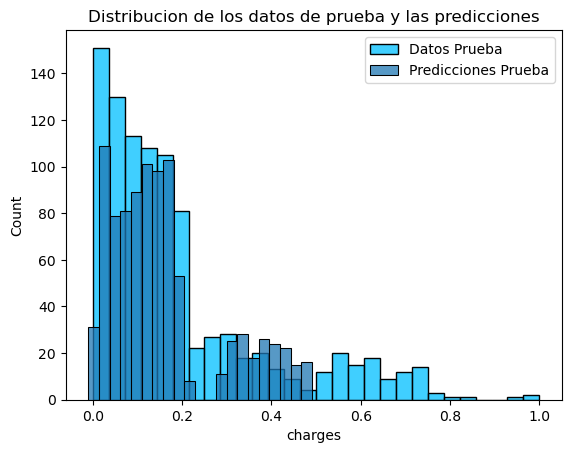

In [406]:
r2_test_9 = r2_score(y_test_des, pred_test_des_9)
rmse_test_9 = root_mean_squared_error(y_test_des, pred_test_des_9)
mae_test_9 = mean_absolute_error(y_test_des, pred_test_des_9)
mape_test_9 = mean_absolute_percentage_error(y_test_des, pred_test_des_9)

print(f'Las metricas de desempeño en prueba para Perceptron Multicapa son:\nR2: {r2_test_9:.4f}\nRMSE: {rmse_test_9:.4f}\nMAE: {mae_test_9:.4f}\nMAPE: {mape_test_9:.4f}')
sb.histplot(data = y_test_des, x ='charges' , color='deepskyblue',label = 'Datos Prueba')
sb.histplot(pred_test_des_9, label = 'Predicciones Prueba')
plt.legend()
plt.title('Distribucion de los datos de prueba y las predicciones')
plt.show()

# **Construcción del Pipeline del Modelo**

- Identificar las variables a ser ignoradas - No hay pero se deja en el codigo
- Implementar los mecanismos de imputación de datos nulos
- Implementar las transformaciones de datos (Escalamientos y Codificaciones)
- Implementar el modelo elegido

In [407]:
#los datos estaban muy bien - en la prep datos al cambiarlos el pipeline lo que hace - procesamiento de los datos ,  
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

In [408]:
data = pd.read_csv('datos_caso_3.csv')
target = 'charges'
X = data.drop(columns = [target])
y = data[[target]]

In [409]:
#Identificar las variables numéricas y categóricas, además las variables a ignorar
all_num = X.select_dtypes(include = ['int64', 'float64']).columns.to_list()
all_cat = X.select_dtypes(include = ['object']).columns.to_list()
num_features = [c for c in all_num ]
cat_features = [c for c in all_cat ]

In [410]:
#Crear los pipelines de imputación y transformación
###Imputador por vecindad a las variables numéricas y un escalamiento MinMax
###Imputador simple por moda a las variables categóricas y una codificación OneHot
num_pipe = Pipeline(steps = [('scaler', MinMaxScaler())]) #se hace la escalada 
cat_pipe = Pipeline(steps = [('encoder', OneHotEncoder())]) # con onehotenc 
#el pipeline lo hace solo 
# podriamos quitar la parte del imputer pero es bueno por si al momento de hacer el modelo igual se deja 


In [411]:
num_pipe

Pipeline(steps=[('scaler', MinMaxScaler())])

In [412]:
cat_pipe

Pipeline(steps=[('encoder', OneHotEncoder())])

In [413]:
preprocessor = ColumnTransformer(transformers = [('num', num_pipe, num_features), ('cat', cat_pipe, cat_features)], remainder = 'drop') #se dropea lo que no quedo en lo s otros pipe  
#ejecuta el pipe


In [ ]:
#(criterion='squared_error', loss='absolute_error', n_estimators=700)
#aquí sacamos los hiperparametros de la que nos tiro el mejor mape 

model = GradientBoostingRegressor(
  criterion='squared_error',
  n_estimators=700,
  loss= 'absolute_error'
)

pipe_model = Pipeline(
  steps=[
    ('preprocessor', preprocessor),
    ('model', model)
  ]
)
pipe_model
#ahi imprimio el step de ese pipe model 


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('model',
                 GradientBoostingRegressor(loss='absolute_error',
                                           n_estimators=1000))])

In [415]:
X_train, X_test, y_train, y_test = train_test_split(
  X, y, train_size=0.7
)

pipe_model.fit(X_train, y_train)
#ya se le hizo el fit al modelo 

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('model',
                 GradientBoostingRegressor(loss='absolute_error',
                                           n_estimators=1000))])

In [416]:
y_pred = pipe_model.predict(X_test)
y_pred
#predijo que es lo que dió

array([12695.22580225, 11685.42167872,  6058.77814378, 26393.19234305,
        7732.8838243 , 40759.7152927 , 11148.42274871, 42791.61584081,
        4840.45100659,  9962.87833216,  1870.36368174,  7521.21721546,
        9418.49840759,  9556.97685927, 30414.21719121, 39791.55807269,
        7502.67415328,  2254.02249524, 24167.9505908 ,  8306.2784354 ,
        4365.69257451, 13523.22201885,  2199.03420188,  3977.20186649,
        4399.71270513,  3541.39872254, 20148.5858806 , 21740.52251611,
       12101.46434754,  2218.17480749, 11138.30523476, 15704.63624727,
       39186.68038286, 13885.97536013, 20046.44680052,  2871.04567769,
        6271.04802458,  2557.6466881 ,  5461.32190999, 34827.69051083,
        8829.29824649, 11859.65763295,  6946.6443119 , 11755.6915692 ,
        3601.21274916,  6269.93286632,  1779.2406915 ,  2908.29859781,
       11645.81623524, 34240.87130855, 16641.6824098 ,  1621.52106737,
       17691.8847226 ,  2196.55900445, 12924.502175  ,  4403.94326959,
      

In [420]:
import joblib #job lib es para exportar modelos 
joblib.dump(pipe_model, 'modelo_regresion_caso_3_final.pkl')

['modelo_regresion_caso_3_final.pkl']

In [421]:
modelo_guardado = joblib.load('modelo_regresion_caso_3_final.pkl')
modelo_guardado.predict(X_test)
#cargar el modelo 


array([12695.22580225, 11685.42167872,  6058.77814378, 26393.19234305,
        7732.8838243 , 40759.7152927 , 11148.42274871, 42791.61584081,
        4840.45100659,  9962.87833216,  1870.36368174,  7521.21721546,
        9418.49840759,  9556.97685927, 30414.21719121, 39791.55807269,
        7502.67415328,  2254.02249524, 24167.9505908 ,  8306.2784354 ,
        4365.69257451, 13523.22201885,  2199.03420188,  3977.20186649,
        4399.71270513,  3541.39872254, 20148.5858806 , 21740.52251611,
       12101.46434754,  2218.17480749, 11138.30523476, 15704.63624727,
       39186.68038286, 13885.97536013, 20046.44680052,  2871.04567769,
        6271.04802458,  2557.6466881 ,  5461.32190999, 34827.69051083,
        8829.29824649, 11859.65763295,  6946.6443119 , 11755.6915692 ,
        3601.21274916,  6269.93286632,  1779.2406915 ,  2908.29859781,
       11645.81623524, 34240.87130855, 16641.6824098 ,  1621.52106737,
       17691.8847226 ,  2196.55900445, 12924.502175  ,  4403.94326959,
      